In [20]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from imblearn.combine import SMOTEENN
from sklearn import metrics

#visualization
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter

In [19]:
pip install folium

     |████████████████████████████████| 92kB 1.8MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
data = pd.read_csv("MVC.csv")
print(data.columns)

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'NUMTIME'],
      dtype='object')


In [3]:
data = data[['BOROUGH','NUMTIME','LONGITUDE','LATITUDE','CONTRIBUTING FACTOR VEHICLE 1','NUMBER OF PERSONS KILLED','NUMBER OF PERSONS INJURED','NUMBER OF PEDESTRIANS KILLED','NUMBER OF PEDESTRIANS INJURED']]
data['PERSONS_AFFECTED'] = data['NUMBER OF PERSONS KILLED'] + data['NUMBER OF PERSONS INJURED']
data['PEDESTRIANS_AFFECTED'] = data['NUMBER OF PEDESTRIANS KILLED'] + data['NUMBER OF PEDESTRIANS INJURED']

In [4]:
borough_dummy = data.BOROUGH.str.get_dummies()
data = pd.concat([data,borough_dummy],axis=1)

data = data.dropna()
data = data[data.LONGITUDE !=0]

data['PERSONS_TF']=0
data.loc[data['PERSONS_AFFECTED'] > 0, 'PERSONS_TF']= 1
data.loc[data['PERSONS_AFFECTED'] == 0, 'PERSONS_TF']= 0

In [5]:
value_counts = data["CONTRIBUTING FACTOR VEHICLE 1"].value_counts(ascending=True)
remove = value_counts[value_counts <= 20].index
data = data[~data['CONTRIBUTING FACTOR VEHICLE 1'].isin(remove)]

data['CONTRIBUTING FACTOR VEHICLE 1'] = data['CONTRIBUTING FACTOR VEHICLE 1'].replace(['Driver Inattention/Distraction','Following Too Closely','Failure to Yield Right-of-Way','Backing Unsafely','Passing Too Closely','Unsafe Lane Changing','Passing or Lane Usage Improper','Turning Improperly','Traffic Control Disregarded','Driver Inexperience','Reaction to Uninvolved Vehicle','Unsafe Speed','Fatigued/Drowsy','Alcohol Involvement','Lost Consciousness','Aggressive Driving/Road Rage','Fell Asleep','Illnes','Drugs (illegal)','Drugs (Illegal)','Texting','Outside Car Distraction','Passenger Distraction','Prescription Medication','Failure to Keep Right','Illness','Other Electronic Device','Cell Phone (hand-Held)','Cell Phone (hands-free)','Eating or Drinking','Pedestrian/Bicyclist/Other Pedestrian Error/Confusion','Physical Disability','Reaction to Other Uninvolved Vehicle','Using On Board Navigation Device','Tinted Windows','Vehicle Vandalism','Cell Phone (hand-held)'],'Human')
data['CONTRIBUTING FACTOR VEHICLE 1'] = data['CONTRIBUTING FACTOR VEHICLE 1'].replace(['Other Vehicular','Oversized Vehicle','Brakes Defective','Steering Failure','Tire Failure/Inadequate','Driverless/Runaway Vehicle','Accelerator Defective','Other Lighting Defects','Tow Hitch Defective','Headlights Defective','Windshield Inadequate'],'Vehicular')
data['CONTRIBUTING FACTOR VEHICLE 1'] = data['CONTRIBUTING FACTOR VEHICLE 1'].replace(['Pavement Slippery','View Obstructed/Limited','Glare','Obstruction/Debris','Pavement Defective','Animals Action','Lane Marking Improper/Inadequate','Traffic Control Device Improper/Non-Working','Shoulders Defective/Improper'],'Environmental')
data['CONTRIBUTING FACTOR VEHICLE 1'] = data['CONTRIBUTING FACTOR VEHICLE 1'].replace(['80'],'Unspecified')

In [6]:
factor_dummy = data['CONTRIBUTING FACTOR VEHICLE 1'].str.get_dummies()
data = pd.concat([data,factor_dummy],axis=1)

In [7]:
pred = list(zip(data['NUMTIME'],data['MANHATTAN'],data['QUEENS'],data['BRONX'],data['STATEN ISLAND'],data['BROOKLYN'],data['Human'],data['Environmental'],data['Vehicular'],data['Unspecified']))
resp = data['PERSONS_TF']
sm = SMOTEENN(random_state=42)
x_res,y_res = sm.fit_resample(pred,resp)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 118888, 1: 92160})


In [34]:
X_feat = x_res
y = y_res
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)


t = RandomForestClassifier(criterion='entropy',max_depth=30,min_samples_leaf=10)

t.fit(X_train,y_train)
y_test_pred = t.predict(X_test)


print("Classification Report:\n", metrics.classification_report(y_test,y_test_pred))
print("Null accuracy on the test set: ",y_test.mean())
print("Sensitivity/Recall (TPR): ",metrics.recall_score(y_test,y_test_pred,average='micro'))
print("Precision (PPV): ", metrics.precision_score(y_test,y_test_pred,average='micro'))
print("Accuracy:",metrics.accuracy_score(y_test, y_test_pred))
cm = metrics.confusion_matrix(y_test, y_test_pred)
cm

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95     23833
           1       0.95      0.91      0.93     18377

    accuracy                           0.94     42210
   macro avg       0.94      0.94      0.94     42210
weighted avg       0.94      0.94      0.94     42210

Null accuracy on the test set:  0.43537076522151147
Sensitivity/Recall (TPR):  0.9391139540393272
Precision (PPV):  0.9391139540393272
Accuracy: 0.9391139540393272


array([[22870,   963],
       [ 1607, 16770]])

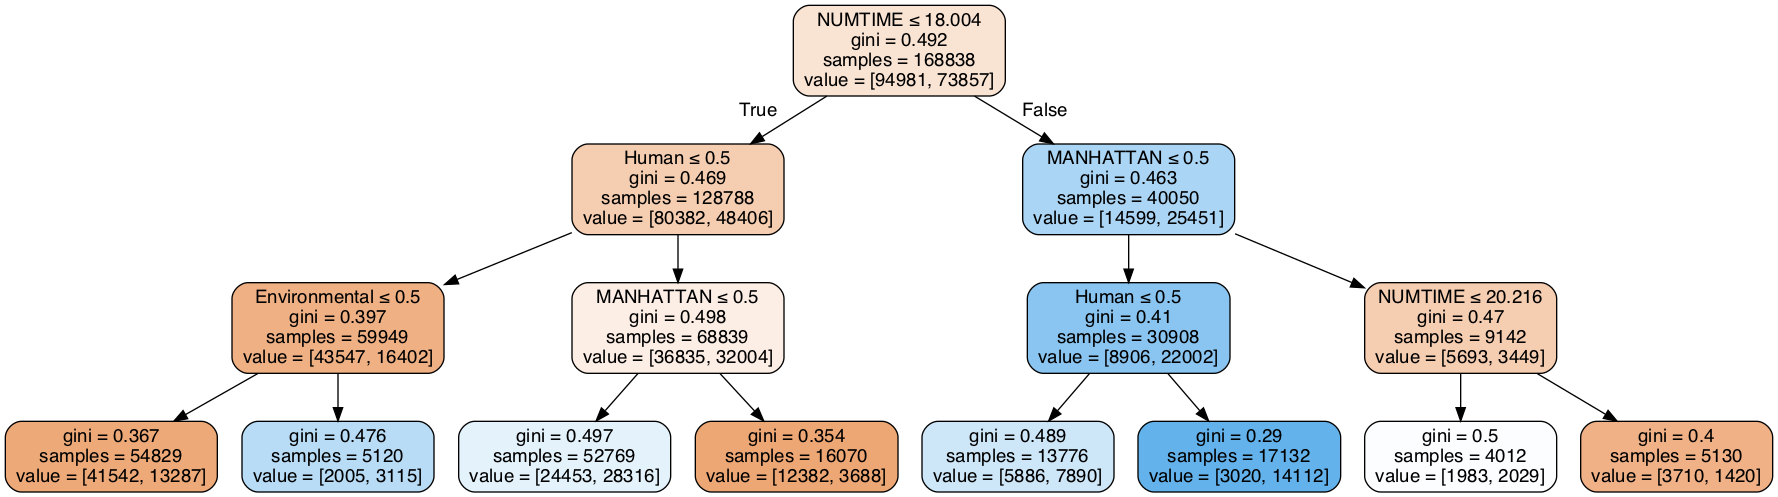

In [32]:
t = DecisionTreeClassifier(max_depth=3,min_samples_leaf=10)

t.fit(X_train,y_train)

dot_data = StringIO()  
export_graphviz(t, out_file=dot_data,  
                    feature_names=['NUMTIME','MANHATTAN','QUEENS','BRONX','STATEN ISLAND','BROOKLYN','Human','Environmental','Vehicular','Unspecified'],
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

[Text(30.5, 0.5, 'Actual Class'),
 Text(0.5, 30.5, 'Predicted Class'),
 Text(0.5, 1, 'Normalized Confusion Matrix')]

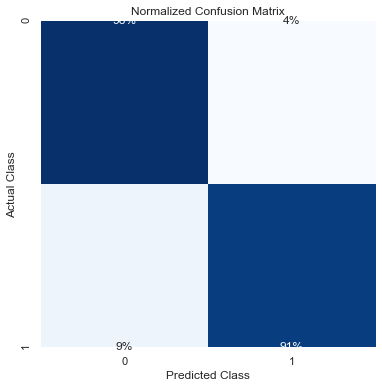

In [35]:
test_cf = confusion_matrix(y_test,t.predict(X_test))
test_cf = test_cf.astype('float') / test_cf.sum(axis=1)[:, np.newaxis]
test_cf = pd.DataFrame((test_cf))
                           
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(test_cf,annot=True,cmap='Blues',cbar=False,fmt='.0%')
ax.set(xlabel='Predicted Class',ylabel='Actual Class',title='Normalized Confusion Matrix')

In [25]:
importance = t.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.87996
Feature: 1, Score: 0.03640
Feature: 2, Score: 0.00631
Feature: 3, Score: 0.00596
Feature: 4, Score: 0.00365
Feature: 5, Score: 0.00850
Feature: 6, Score: 0.02391
Feature: 7, Score: 0.00724
Feature: 8, Score: 0.00875
Feature: 9, Score: 0.01934


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

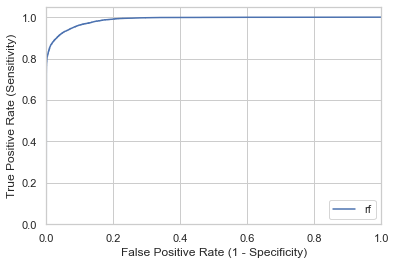

In [22]:
X_feat = x_res
y = y_res
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)


t = RandomForestClassifier(criterion='entropy',max_depth=30,min_samples_leaf=10)

t.fit(X_train,y_train)
y_test_pred = t.predict_proba(X_test)[:,1]
new = np.concatenate((y_test.values.reshape(-1,1),y_test_pred.reshape(-1,1)),axis=1)

fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_test_pred)

sns.mpl.pyplot.plot(fpr_rf, tpr_rf,label="rf")
sns.mpl.pyplot.xlim([0, 1])
sns.mpl.pyplot.ylim([0, 1.05])
sns.mpl.pyplot.legend(loc="lower right")
sns.mpl.pyplot.xlabel('False Positive Rate (1 - Specificity)')
sns.mpl.pyplot.ylabel('True Positive Rate (Sensitivity)')

In [27]:

fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_test_pred)
print("Model 1 Random Forest AUC: ",metrics.roc_auc_score(y_test, y_test_pred))




Model 1 Random Forest AUC:  0.9881337216338251


In [26]:
pred=x_res
resp=y_res
logreg = LogisticRegression(C=1e9)
logreg.fit(pred, resp)
end = logreg.predict(pred)
print("The slope is: ",logreg.coef_)
print("The y-intercept is:",logreg.intercept_)
print("The r^2 is:",metrics.r2_score(resp,end))
print("The MSE is:",metrics.mean_squared_error(resp, end))

The slope is:  [[ 0.0495501  -0.97389111 -0.0146395   0.30009103 -0.35722772  0.31041747
   0.29705853  0.67105208 -0.95252482 -0.75083564]]
The y-intercept is: [-0.73524984]
The r^2 is: -0.40466006696779
The MSE is: 0.34553276979644443


In [10]:
X_feat = x_res
y = y_res
X_feat_train,X_feat_test, y_feat_train,y_feat_test = train_test_split(X_feat,y,test_size=0.2)

dtc = RandomForestClassifier()
grid={'max_depth':[1,2,3,4,5,10,20,30],
        'criterion':['gini','entropy'],
        'min_samples_leaf':[10,20,30,50,60]}

gs = GridSearchCV(dtc,grid,cv=3,verbose=True,return_train_score=False,n_jobs=-1)
gs.fit(X_feat,y)

scores = pd.DataFrame(gs.cv_results_).filter(regex='param_+|mean_test_score'
                                            ).sort_values('mean_test_score',
                                                          ascending=False).reset_index().drop(['index'],axis=1)
scores.head(10)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.7min
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 19.7min finished


,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_score
0,entropy,30,10,0.930376
1,gini,30,10,0.929319
2,gini,20,10,0.928196
3,entropy,20,10,0.927443
4,gini,30,20,0.900184
5,entropy,30,20,0.900174
6,gini,20,20,0.899156
7,entropy,20,20,0.898554
8,gini,30,30,0.886571
9,gini,20,30,0.885936


In [44]:
X_feat = x_res
y = y_res
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)


t = RandomForestClassifier(criterion='entropy',max_depth=4,min_samples_leaf=20)

t.fit(X_train,y_train)
y_test_pred = t.predict(X_test)


print("Classification Report:\n", metrics.classification_report(y_test,y_test_pred))
print("Null accuracy on the test set: ",y_test.mean())
print("Sensitivity/Recall (TPR): ",metrics.recall_score(y_test,y_test_pred,average='micro'))
print("Precision (PPV): ", metrics.precision_score(y_test,y_test_pred,average='micro'))
cm = metrics.confusion_matrix(y_test, y_test_pred)
cm

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.44      0.50    106182
           1       0.54      0.67      0.60    105802

    accuracy                           0.55    211984
   macro avg       0.56      0.55      0.55    211984
weighted avg       0.56      0.55      0.55    211984

Null accuracy on the test set:  0.499103705940071
Sensitivity/Recall (TPR):  0.5534049739602989
Precision (PPV):  0.5534049739602989


array([[46665, 59517],
       [35154, 70648]])

[Text(30.5, 0.5, 'Actual Class'),
 Text(0.5, 30.5, 'Predicted Class'),
 Text(0.5, 1, 'Confusion Matrix')]

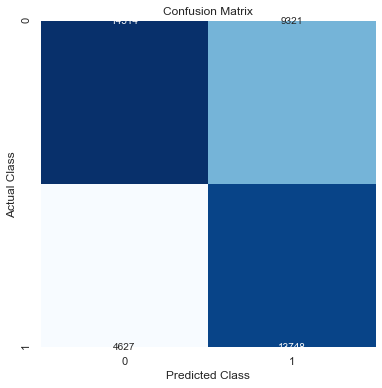

In [13]:
test_cf = pd.DataFrame(confusion_matrix(y_test,t.predict(X_test)))

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(test_cf,annot=True,fmt='d',cmap='Blues',cbar=False)
ax.set(xlabel='Predicted Class',ylabel='Actual Class',title='Confusion Matrix')

[Text(30.5, 0.5, 'Actual Class'),
 Text(0.5, 30.5, 'Predicted Class'),
 Text(0.5, 1, 'Normalized Confusion Matrix')]

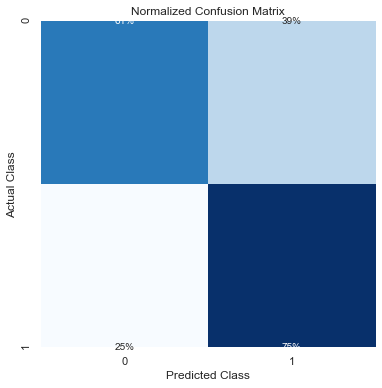

In [14]:
test_cf = confusion_matrix(y_test,t.predict(X_test))
test_cf = test_cf.astype('float') / test_cf.sum(axis=1)[:, np.newaxis]
test_cf = pd.DataFrame((test_cf))
                           
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(test_cf,annot=True,cmap='Blues',cbar=False,fmt='.0%')
ax.set(xlabel='Predicted Class',ylabel='Actual Class',title='Normalized Confusion Matrix')

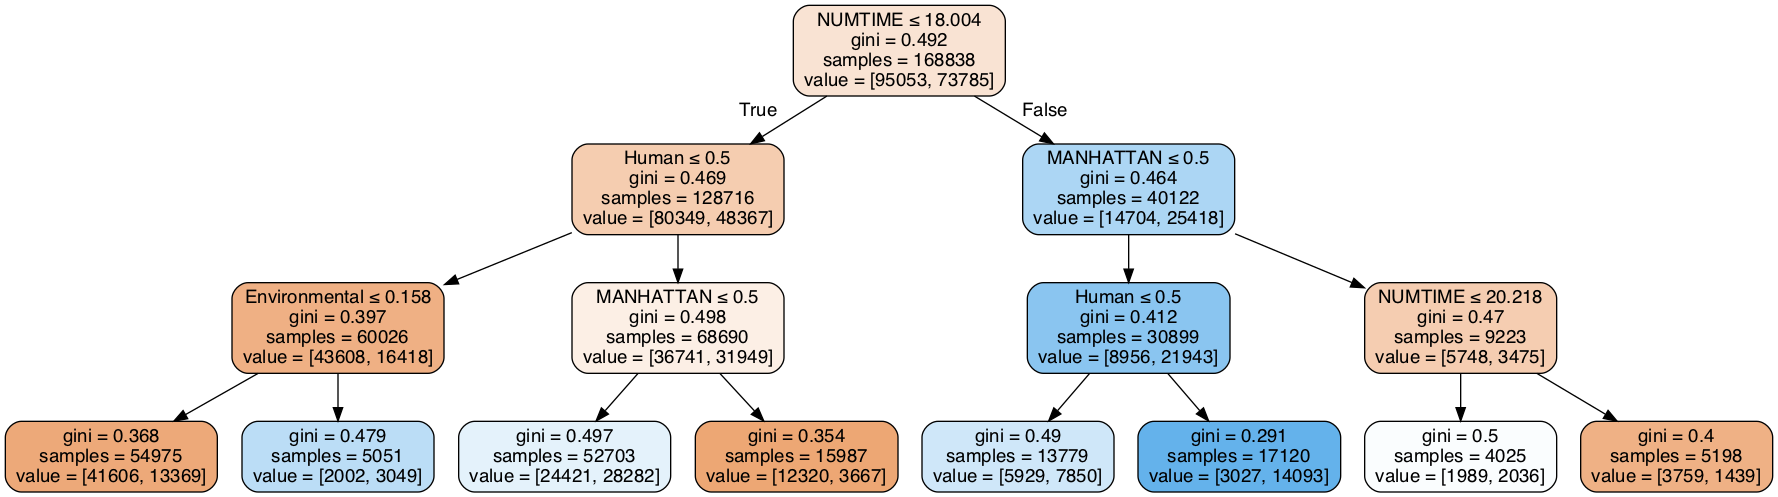

In [12]:
t = DecisionTreeClassifier(max_depth=3,min_samples_leaf=10)

t.fit(X_train,y_train)

dot_data = StringIO()  
export_graphviz(t, out_file=dot_data,  
                    feature_names=['NUMTIME','MANHATTAN','QUEENS','BRONX','STATEN ISLAND','BROOKLYN','Human','Environmental','Vehicular','Unspecified'],
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
X_feat = x_res
y = y_res
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)


t = RandomForestClassifier(criterion='entropy',max_depth=4,min_samples_leaf=20)

t.fit(X_train,y_train)
y_test_pred = t.predict(X_test)


print("Classification Report:\n", metrics.classification_report(y_test,y_test_pred))
print("Null accuracy on the test set: ",y_test.mean())
print("Sensitivity/Recall (TPR): ",metrics.recall_score(y_test,y_test_pred,average='micro'))
print("Precision (PPV): ", metrics.precision_score(y_test,y_test_pred,average='micro'))
cm = metrics.confusion_matrix(y_test, y_test_pred)
cm

In [12]:
X_feat = x_res

y = y_res

X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)

depths = [1,2,3,4,5,10,15,20,25,30]
accs = []
for i in depths:
    dtc = RandomForestClassifier(max_depth=i,criterion='entropy',min_samples_leaf=20)
    dtc.fit(X_train,y_train)
    accs.append(dtc.score(X_test,y_test))
    
print('Scores:\n',pd.DataFrame({'Accuracy':accs},index=depths))

Scores:
     Accuracy
1   0.550961
2   0.553084
3   0.552759
4   0.553528
5   0.553716
10  0.562797
15  0.574421
20  0.579440
25  0.580950
30  0.580638


[Text(30.5, 0.5, 'Actual Class'),
 Text(0.5, 30.5, 'Predicted Class'),
 Text(0.5, 1, 'Confusion Matrix')]

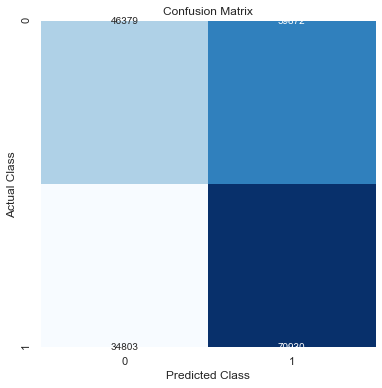

In [13]:
test_cf = pd.DataFrame(confusion_matrix(y_test,t.predict(X_test)))

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(test_cf,annot=True,fmt='d',cmap='Blues',cbar=False)
ax.set(xlabel='Predicted Class',ylabel='Actual Class',title='Confusion Matrix')

[Text(30.5, 0.5, 'Actual Class'),
 Text(0.5, 30.5, 'Predicted Class'),
 Text(0.5, 1, 'Normalized Confusion Matrix')]

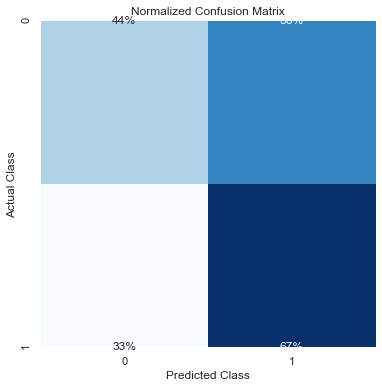

In [45]:
test_cf = confusion_matrix(y_test,t.predict(X_test))
test_cf = test_cf.astype('float') / test_cf.sum(axis=1)[:, np.newaxis]
test_cf = pd.DataFrame((test_cf))
                           
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(test_cf,annot=True,cmap='Blues',cbar=False,fmt='.0%')
ax.set(xlabel='Predicted Class',ylabel='Actual Class',title='Normalized Confusion Matrix')

In [ ]:
X_feat = data[['LATITUDE',"LONGITUDE",'NUMTIME','BRONX','BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND','Environmental','Human','Unspecified','Vehicular']]
y = resp
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)

dtc = MLPClassifier(verbose=True)
grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'max_iter': [100,200,500,1000,2000]}

gs = GridSearchCV(dtc,grid,cv=3,verbose=True,return_train_score=False)
gs.fit(X_feat,y)

scores = pd.DataFrame(gs.cv_results_).filter(regex='param_+|mean_test_score'
                                            ).sort_values('mean_test_score',
                                                          ascending=False).reset_index().drop(['index'],axis=1)
scores.head(10)

Text(0, 0.5, 'True Positive Rate (Sensitivity)')

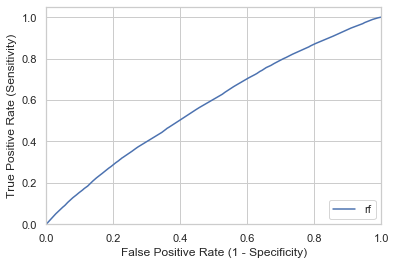

In [25]:
X_feat = x_res

y = y_res

X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)


t2 = RandomForestClassifier(n_estimators=100,max_depth=4,min_samples_leaf=20)

t2.fit(X_train,y_train)
y_test_pred = t2.predict_proba(X_test)[:,1]
new = np.concatenate((y_test.values.reshape(-1,1),y_test_pred.reshape(-1,1)),axis=1)

fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_test_pred)

sns.mpl.pyplot.plot(fpr_rf, tpr_rf,label="rf")
sns.mpl.pyplot.xlim([0, 1])
sns.mpl.pyplot.ylim([0, 1.05])
sns.mpl.pyplot.legend(loc="lower right")
sns.mpl.pyplot.xlabel('False Positive Rate (1 - Specificity)')
sns.mpl.pyplot.ylabel('True Positive Rate (Sensitivity)')

In [26]:

fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_test_pred)
print("RF model AUC: ",metrics.roc_auc_score(y_test, y_test_pred))



RF model AUC:  0.5764097822931761


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

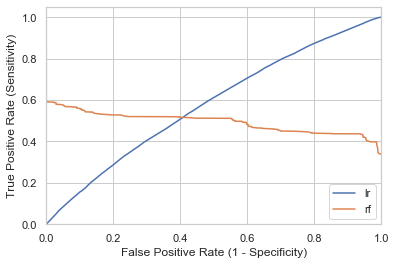

In [16]:

y_test_pred = t.predict_proba(X_test)[:,1]
new = np.concatenate((y_test.values.reshape(-1,1),y_test_pred.reshape(-1,1)),axis=1)

fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_test_pred)
sns.mpl.pyplot.plot(fpr_rf, tpr_rf,label="lr")
sns.mpl.pyplot.plot(fpr_rf, thresholds_rf,label="rf")
sns.mpl.pyplot.xlim([0, 1])
sns.mpl.pyplot.ylim([0, 1.05])
sns.mpl.pyplot.legend(loc="lower right")
sns.mpl.pyplot.xlabel('False Positive Rate (1 - Specificity)')
sns.mpl.pyplot.ylabel('True Positive Rate (Sensitivity)')

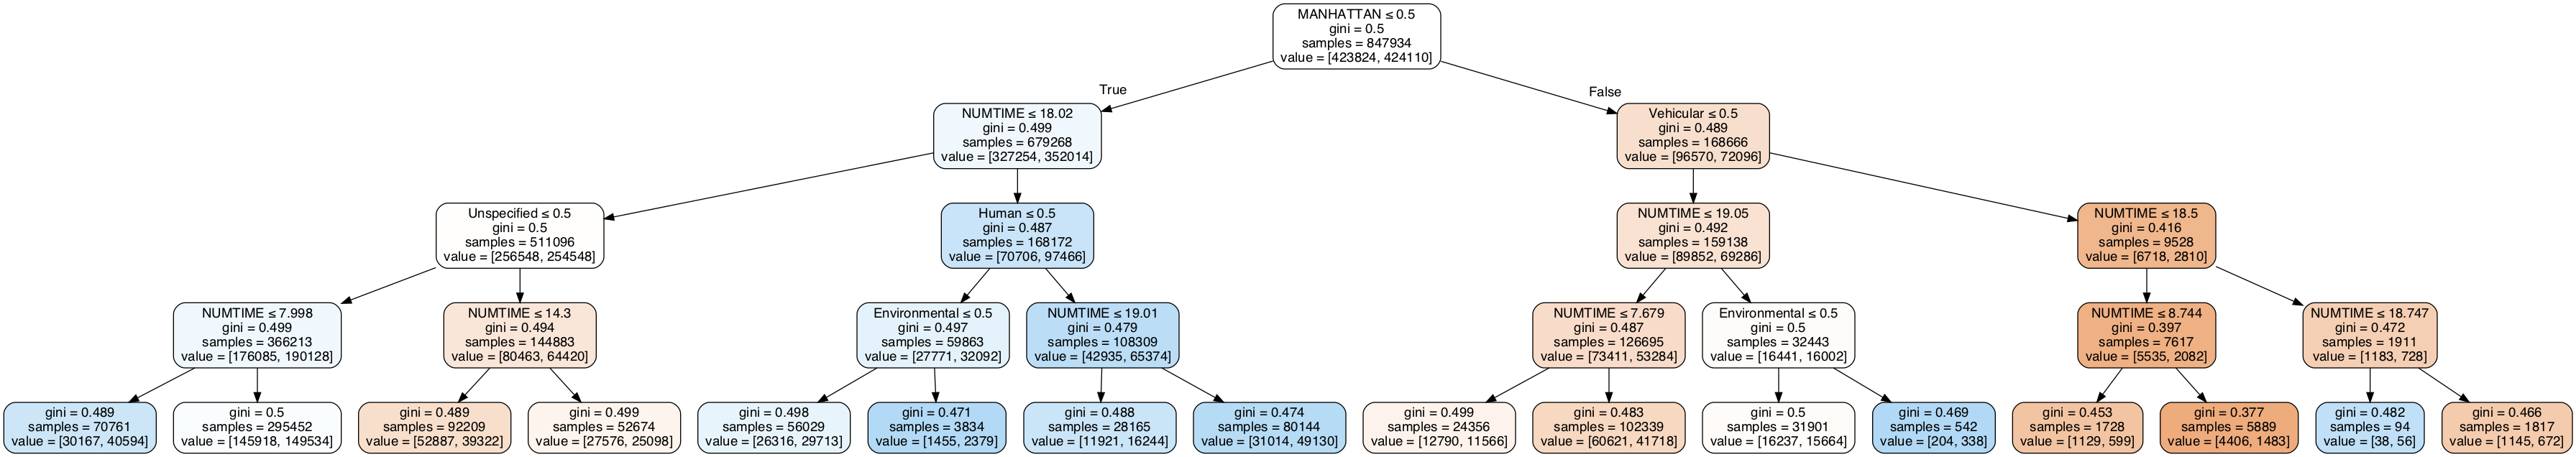

In [9]:
pred = list(zip(data['NUMTIME'],data['MANHATTAN'],data['QUEENS'],data['BRONX'],data['STATEN ISLAND'],data['BROOKLYN'],data['Human'],data['Environmental'],data['Vehicular'],data['Unspecified']))
X_feat= x_res
y = y_res

X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)


t = DecisionTreeClassifier(max_depth=4,min_samples_leaf=20)

t.fit(X_train,y_train)

dot_data = StringIO()  
export_graphviz(t, out_file=dot_data,  
                    feature_names=['NUMTIME','MANHATTAN','QUEENS','BRONX','STATEN ISLAND','BROOKLYN','Human','Environmental','Vehicular','Unspecified'],
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
data1 = pd.read_csv("MVC.csv")
print(data.columns)

In [ ]:
data1['PERSONS_AFFECTED'] = data1['NUMBER OF PERSONS KILLED'] + data1['NUMBER OF PERSONS INJURED']
data1['PEDESTRIANS_AFFECTED'] = data1['NUMBER OF PEDESTRIANS KILLED'] + data1['NUMBER OF PEDESTRIANS INJURED']

In [ ]:
borough_dummy = data1.BOROUGH.str.get_dummies()
data1 = pd.concat([data1,borough_dummy],axis=1)

data1 = data1.dropna()
data1 = data1[data1.LONGITUDE !=0]

data1['PERSONS_TF']=0
data1.loc[data1['PERSONS_AFFECTED'] > 0, 'PERSONS_TF']= 1
data1.loc[data1['PERSONS_AFFECTED'] == 0, 'PERSONS_TF']= 0

In [ ]:
value_counts = data1["CONTRIBUTING FACTOR VEHICLE 1"].value_counts(ascending=True)
remove = value_counts[value_counts <= 20].index
data1 = data1[~data1['CONTRIBUTING FACTOR VEHICLE 1'].isin(remove)]

data1['CONTRIBUTING FACTOR VEHICLE 1'] = data1['CONTRIBUTING FACTOR VEHICLE 1'].replace(['Driver Inattention/Distraction','Following Too Closely','Failure to Yield Right-of-Way','Backing Unsafely','Passing Too Closely','Unsafe Lane Changing','Passing or Lane Usage Improper','Turning Improperly','Traffic Control Disregarded','Driver Inexperience','Reaction to Uninvolved Vehicle','Unsafe Speed','Fatigued/Drowsy','Alcohol Involvement','Lost Consciousness','Aggressive Driving/Road Rage','Fell Asleep','Illnes','Drugs (illegal)','Drugs (Illegal)','Texting','Outside Car Distraction','Passenger Distraction','Prescription Medication','Failure to Keep Right','Illness','Other Electronic Device','Cell Phone (hand-Held)','Cell Phone (hands-free)','Eating or Drinking','Pedestrian/Bicyclist/Other Pedestrian Error/Confusion','Physical Disability','Reaction to Other Uninvolved Vehicle','Using On Board Navigation Device','Tinted Windows','Vehicle Vandalism','Cell Phone (hand-held)'],'Human')
data1['CONTRIBUTING FACTOR VEHICLE 1'] = data1['CONTRIBUTING FACTOR VEHICLE 1'].replace(['Other Vehicular','Oversized Vehicle','Brakes Defective','Steering Failure','Tire Failure/Inadequate','Driverless/Runaway Vehicle','Accelerator Defective','Other Lighting Defects','Tow Hitch Defective','Headlights Defective','Windshield Inadequate'],'Vehicular')
data1['CONTRIBUTING FACTOR VEHICLE 1'] = data1['CONTRIBUTING FACTOR VEHICLE 1'].replace(['Pavement Slippery','View Obstructed/Limited','Glare','Obstruction/Debris','Pavement Defective','Animals Action','Lane Marking Improper/Inadequate','Traffic Control Device Improper/Non-Working','Shoulders Defective/Improper'],'Environmental')
data1['CONTRIBUTING FACTOR VEHICLE 1'] = data1['CONTRIBUTING FACTOR VEHICLE 1'].replace(['80'],'Unspecified')

In [ ]:
factor_dummy = data1['CONTRIBUTING FACTOR VEHICLE 1'].str.get_dummies()
data1 = pd.concat([data1,factor_dummy],axis=1)

In [ ]:
pred1 = list(zip(data1['NUMTIME'],data1['MANHATTAN'],data1['QUEENS'],data1['BRONX'],data1['STATEN ISLAND'],data1['BROOKLYN'],data1['Human'],data1['Environmental'],data1['Vehicular'],data1['Unspecified']))
resp1 = data1['PERSONS_TF']
sm = SMOTE(random_state=42)
x_res,y_res = sm.fit_resample(pred,resp)
print('Resampled dataset shape %s' % Counter(y_res))

In [11]:
pred=x_res
resp=y_res
logreg = LogisticRegression(C=1e9)
logreg.fit(pred, resp)
end = logreg.predict(pred)
print("The slope is: ",logreg.coef_)
print("The y-intercept is:",logreg.intercept_)
print("The r^2 is:",metrics.r2_score(y,end))
print("The MSE is:",metrics.mean_squared_error(y, end))

The slope is:  [[ 0.0495501  -0.97389111 -0.0146395   0.30009103 -0.35722772  0.31041747
   0.29705853  0.67105208 -0.95252482 -0.75083564]]
The y-intercept is: [-0.73524984]
The r^2 is: -0.40466006696779
The MSE is: 0.34553276979644443


ValueError: x and y must have same first dimension, but have shapes (654468,) and (1059918,)

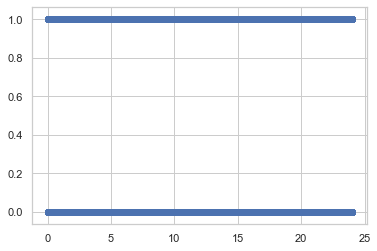

In [49]:
plt.rcParams['agg.path.chunksize'] = 10000
sns.mpl.pyplot.scatter(data.NUMTIME, data.PERSONS_TF)
outcome_probs = logreg.predict_proba(pred)[:, 1]
sns.mpl.pyplot.plot(data.NUMTIME, outcome_probs, color='red')
sns.mpl.pyplot.plot(data.NUMTIME,np.ones(outcome_probs.shape)*.5,'k--')

In [ ]:
plt.rcParams['agg.path.chunksize'] = 10000
sns.mpl.pyplot.scatter(data.NUMTIME, data.PERSONS_TF)
outcome_probs = logreg.predict_proba(pred)[:, 1]
sns.mpl.pyplot.plot(data.NUMTIME, outcome_probs, color='red')
sns.mpl.pyplot.plot(data.NUMTIME,np.ones(outcome_probs.shape)*.5,'k--')

In [ ]:
def motorist_to_bin(x):
    if x == 0:
        return 0
    else:
        return 1
CarData["MOTORIST_AFFECTED"] = CarData["NUMBER OF MOTORIST INJURED"]+CarData["NUMBER OF MOTORIST KILLED"]
CarData['MOTORIST_TF']= CarData["MOTORIST_AFFECTED"].apply(motorist_to_bin)
CarData

In [ ]:
def cyclist_to_bin(x):
    if x == 0:
        return 0
    else:
        return 1
CarData["CYCLIST_AFFECTED"] = CarData["NUMBER OF CYCLIST INJURED"]+CarData["NUMBER OF CYCLIST KILLED"]
CarData['CYCLIST_TF']= CarData["CYCLIST_AFFECTED"].apply(cyclist_to_bin)
CarData

In [ ]:
def pedestrians_to_bin(x):
    if x == 0:
        return 0
    else:
        return 1
CarData["PEDESTRIAN_AFFECTED"] = CarData["NUMBER OF PEDESTRIANS INJURED"]+CarData["NUMBER OF PEDESTRIANS KILLED"]
CarData['PEDESTRIAN_TF']= CarData["PEDESTRIAN_AFFECTED"].apply(cyclist_to_bin)
CarData